#### *GNG5125 Data Science Applications*
#### *Spring-Summer 2022*
#### *Yinruo Jiang (300274815), Rasheeq Mohammad (6849734) , Shahin Mahmud (300274789)*
#### *Assignment 1: Text Classification*

Import necessary libraries

In [1]:
from collections import Counter

# pip install contractions
# Used for expanding contractions
import contractions

import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer

import pandas as pd

import random

import re

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Used for removing accented characters
import unicodedata

# pip install wordcloud
from wordcloud import WordCloud

Download necessary resources

In [2]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rmohamma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rmohamma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rmohamma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Implement helper functions

In [3]:
def read_utf8_file(file):
    bom = "\ufeff"
    text = ""
    with open(file, mode="r", encoding="utf-8") as f:
        text = f.read()
        if text.startswith(bom):
            text = text[1:]
    return text

def extract_title(text):
    pattern = "Title: (.*?)\n"
    match = re.search(pattern, text)
    if match is None:
        return ""
    else:
        return match.group(1).strip()

def extract_author(text):
    pattern = "Author: (.*?)\n"
    match = re.search(pattern, text)
    if match is None:
        return ""
    else:
        return match.group(1).strip()

def find_start_of_book(text):
    pattern = "\*\*\* START OF (.*?) \*\*\*\n"
    match = re.search(pattern, text)
    if match is None:
        return -1
    else:
        return text.find(match.group(0))

def find_end_of_book(text):
    pattern = "\*\*\* END OF (.*?) \*\*\*\n"
    match = re.search(pattern, text)
    if match is None:
        return -1
    else:
        return match.end()

def normalize_accented_chars(text):
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    return text

def expand_contractions(text):
    text = contractions.fix(text)
    return text

def preprocess_text(text, nor_acc:True, exp_con=True):
    if nor_acc:
        text = normalize_accented_chars(text)
    if exp_con:
        text = expand_contractions(text)
    return text

def tokenize_into_words(text):
    text = word_tokenize(text)
    return text

def remove_punctuation(text):
    text = [w for w in text if w.isalpha()]
    return text

def convert_to_lower_case(text):
    text = [w.lower() for w in text]
    return text

def remove_stop_words(text):
    stop_words = stopwords.words("english")
    text = [w for w in text if not w in stop_words]
    return text

def perform_stemming(text):
    stemmer = PorterStemmer()
    text = [stemmer.stem(w) for w in text]
    return text

def perform_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    return text

def clean_text(text, rem_pun:True, con_low=True, rem_sto=True, per_ste=False, per_lem=True):
    if rem_pun:
        text = remove_punctuation(text)
    if con_low:
        text = convert_to_lower_case(text)
    if rem_sto:
        text = remove_stop_words(text)
    if per_ste:
        text = perform_stemming(text)
    if per_lem:
        text = perform_lemmatization(text)
    return text

def find_most_common_words(text_df, authors):
    author_to_most_common_words = {}
    index = 0
    for r in text_df.groupby(["Author"])["Cleaned Samples"].apply(lambda x: " ".join(x)):
        words_to_count = (w for w in r.split(" "))
        words_to_count = [w for w in words_to_count if w]
        c = Counter(words_to_count).most_common(20)
        c = list(zip(*c))
        c = c[0]
        author_to_most_common_words[authors[index]] = c
        index += 1
    return author_to_most_common_words

def draw_word_cloud(words, titles):
    plt.rcParams["figure.figsize"] = [24, 6]
    index = 1
    i = 0
    for key, value in words.items():
        wc = WordCloud().generate((" ").join(value))
        plt.subplot(2, 3, index)
        index += 1
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(titles[i] + " by " + key)
        i += 1

def remove_most_common_words(row ,words):
    new_text_df = [word for word in row["Cleaned Samples"].split() if word not in words[row["Author"]]]
    text = " ".join(new_text_df)       
    return text

def clean_text_advanced(text_df, authors, titles, rem_com=True):
    if rem_com is True:
        new_stop_words = find_most_common_words(text_df, authors)
        draw_word_cloud(new_stop_words, titles)
        text_df["Advanced Cleaned Samples"] = text_df.apply(lambda x: remove_most_common_words(x, new_stop_words), axis=1)

def performing_sampling(text, num_samples=200, num_words_per_sample=100):
    data = []
    string = ""
    count = 0
    for w in text:
        if count < num_words_per_sample:
            string += w
            if count == (num_words_per_sample - 1):
                pass
            else:
                string += " "
            count += 1
        else:
            data.append(string)
            string = ""
            count = 0
    random.seed(0)
    return random.sample(data, num_samples)

Collect, prepare, and clean data

In [4]:
# Texts downloaded from Project Gutenberg
# Genre: science fiction
books = ["pg18458.txt", "pg32825.txt", "pg164.txt", "pg62.txt", "pg139.txt"]

authors = []
titles = []

raw_texts = [] # Read text from file
simplified_texts = [] # Remove copyright and license information
preprocessed_texts = [] # Normalize accented characters and expand contractions
tokenized_texts = [] # Tokenize text into words
cleaned_texts = [] # Clean text (e.g. remove punctuation, convert to lower case, remove stop words, peform stemming, peform lemmatization, etc.)
sampled_texts = [] # Sample text

labeled_texts = []

text_info = []

for b in books:
    raw_text = read_utf8_file(b)
    raw_texts.append(raw_text)
    title = extract_title(raw_text)
    titles.append(title)
    author = extract_author(raw_text)
    authors.append(author)

    start = find_start_of_book(raw_text)
    end = find_end_of_book(raw_text)
    simplified_text = raw_text[start:end]
    simplified_texts.append(simplified_text)

    preprocessed_text = preprocess_text(simplified_text, nor_acc=False, exp_con=True)
    preprocessed_texts.append(preprocessed_text)

    tokenized_text = tokenize_into_words(preprocessed_text)
    tokenized_texts.append(tokenized_text)

    cleaned_text = clean_text(tokenized_text, rem_pun=True, con_low=True, rem_sto=True, per_ste=False, per_lem=True)
    cleaned_texts.append(cleaned_text)

    sampled_text = performing_sampling(cleaned_text)
    sampled_texts.append(sampled_text)

    print(f"Collected, prepared, and cleaned {title} written by {author} ({b})")

for a, t, rt, sit, pt, tt, ct, sat in zip(authors, titles, raw_texts, simplified_texts, tokenized_texts, preprocessed_texts, cleaned_texts, sampled_texts):
    text_info.append((a, t, len(rt), len(sit), len(tt), len(pt), len(ct)))
    labeled_texts += ([(txt, a) for txt in sat])

Collected, prepared, and cleaned Star Born written by Andre Norton (pg18458.txt)
Collected, prepared, and cleaned The Goddess of Atvatabar written by William R. Bradshaw (pg32825.txt)
Collected, prepared, and cleaned Twenty Thousand Leagues under the Sea (slightly abridged) written by Jules Verne (pg164.txt)
Collected, prepared, and cleaned A Princess of Mars written by Edgar Rice Burroughs (pg62.txt)
Collected, prepared, and cleaned The Lost World written by Arthur Conan Doyle (pg139.txt)


Determine frequency distribution of words in cleaned texts

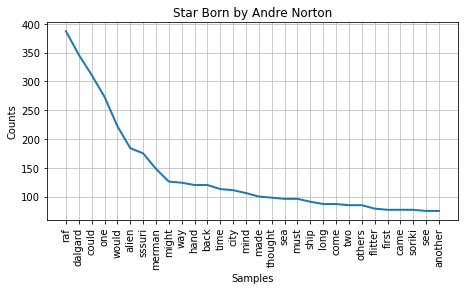

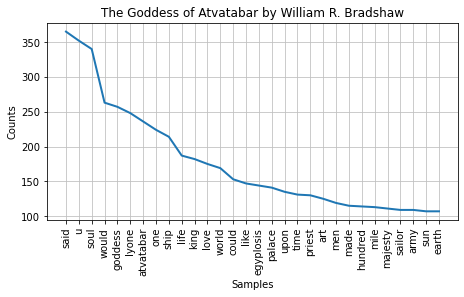

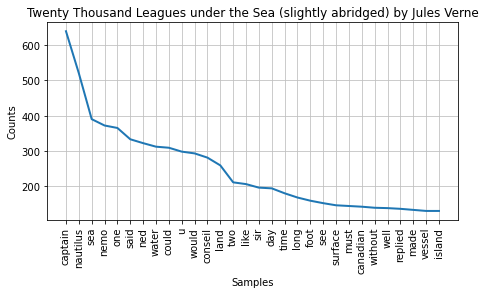

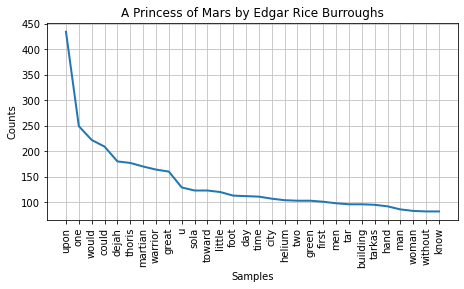

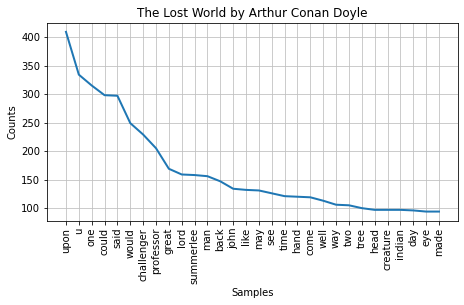

In [5]:
# Frequency distribution of words in cleaned texts
plt.rcParams["figure.figsize"] = [25, 8]
index = 1
for t, a, ct in zip(titles, authors, cleaned_texts):
    plt.subplot(2, 3, index)
    index += 1
    freq_dist = FreqDist(ct)
    title = f"{t} by {a}"
    freq_dist.plot(30, cumulative=False, title=title)
    plt.show()

Create data frame for labeled text

In [6]:
labeled_texts_df = pd.DataFrame(labeled_texts)
labeled_texts_df = labeled_texts_df.rename(columns={0: "Cleaned Samples",
                                                    1: "Author"})
labeled_texts_df

,Cleaned Samples,Author
0,delicately ready flee first hint suspected bel...,Andre Norton
1,explain could one make plain feeling sensible ...,Andre Norton
2,stubbornly gray murmur wonstead went drone ach...,Andre Norton
3,seeming unconcern sssuri first intimation hunt...,Andre Norton
4,raf first reaction must still merman young str...,Andre Norton
...,...,...
995,must difficult one otherwise creature would co...,Arthur Conan Doyle
996,face flashed back went south america solitary ...,Arthur Conan Doyle
997,page disappointing however contained nothing p...,Arthur Conan Doyle
998,one indian group dragged forward edge cliff ki...,Arthur Conan Doyle


Display impact of different data processing steps on number of words in texts

In [7]:
text_info_df = pd.DataFrame(text_info)
text_info_df = text_info_df.rename(columns={0: "Authors",
                                            1: "Titles",
                                            2: "Number of Words in Raw Text",
                                            3: "Number of Words in Simplified Text",
                                            4: "Number of Words in Preprocessed Text",
                                            5: "Number of Words in Tokenized Text",
                                            6: "Number of Words in Cleaned Text"})
text_info_df

,Authors,Titles,Number of Words in Raw Text,Number of Words in Simplified Text,Number of Words in Preprocessed Text,Number of Words in Tokenized Text,Number of Words in Cleaned Text
0,Andre Norton,Star Born,367551,348402,348660,71828,29333
1,William R. Bradshaw,The Goddess of Atvatabar,582554,563280,563659,109510,47696
2,Jules Verne,Twenty Thousand Leagues under the Sea (slightl...,609064,589919,590361,123803,50111
3,Edgar Rice Burroughs,A Princess of Mars,390249,371188,371227,75137,31870
4,Arthur Conan Doyle,The Lost World,443413,424311,424852,89354,34862


<AxesSubplot:>

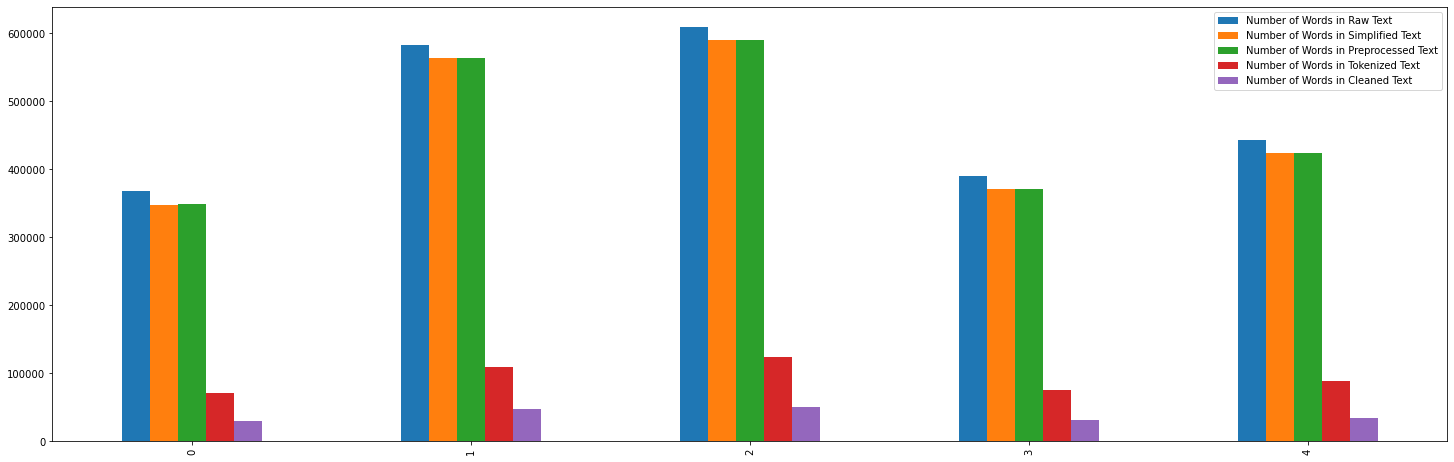

In [8]:
text_info_df.plot.bar()

Perform advanced cleaning; generate word clouds of most common words and remove said words

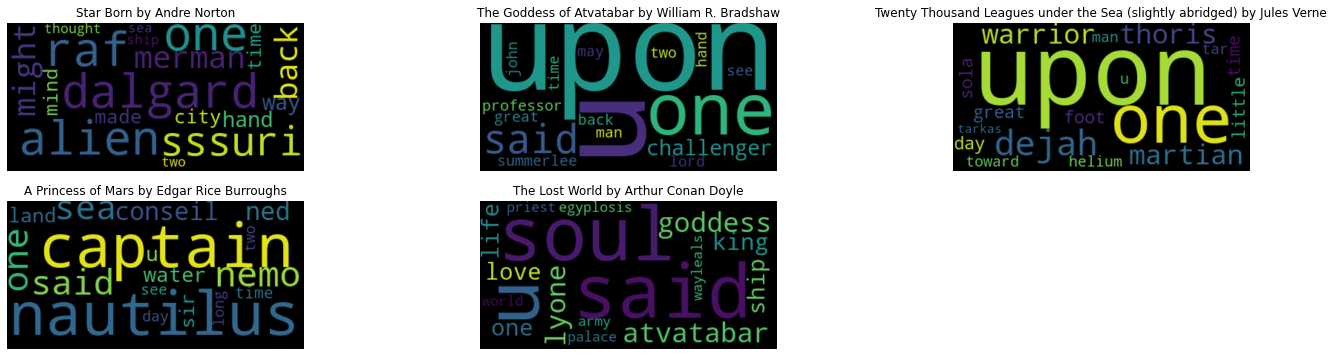

In [9]:
# Will evaluate impact of advanced cleaning in later sections
clean_text_advanced(labeled_texts_df, authors, titles, rem_com=True)

Conduct feature engineering

Create n-gram models

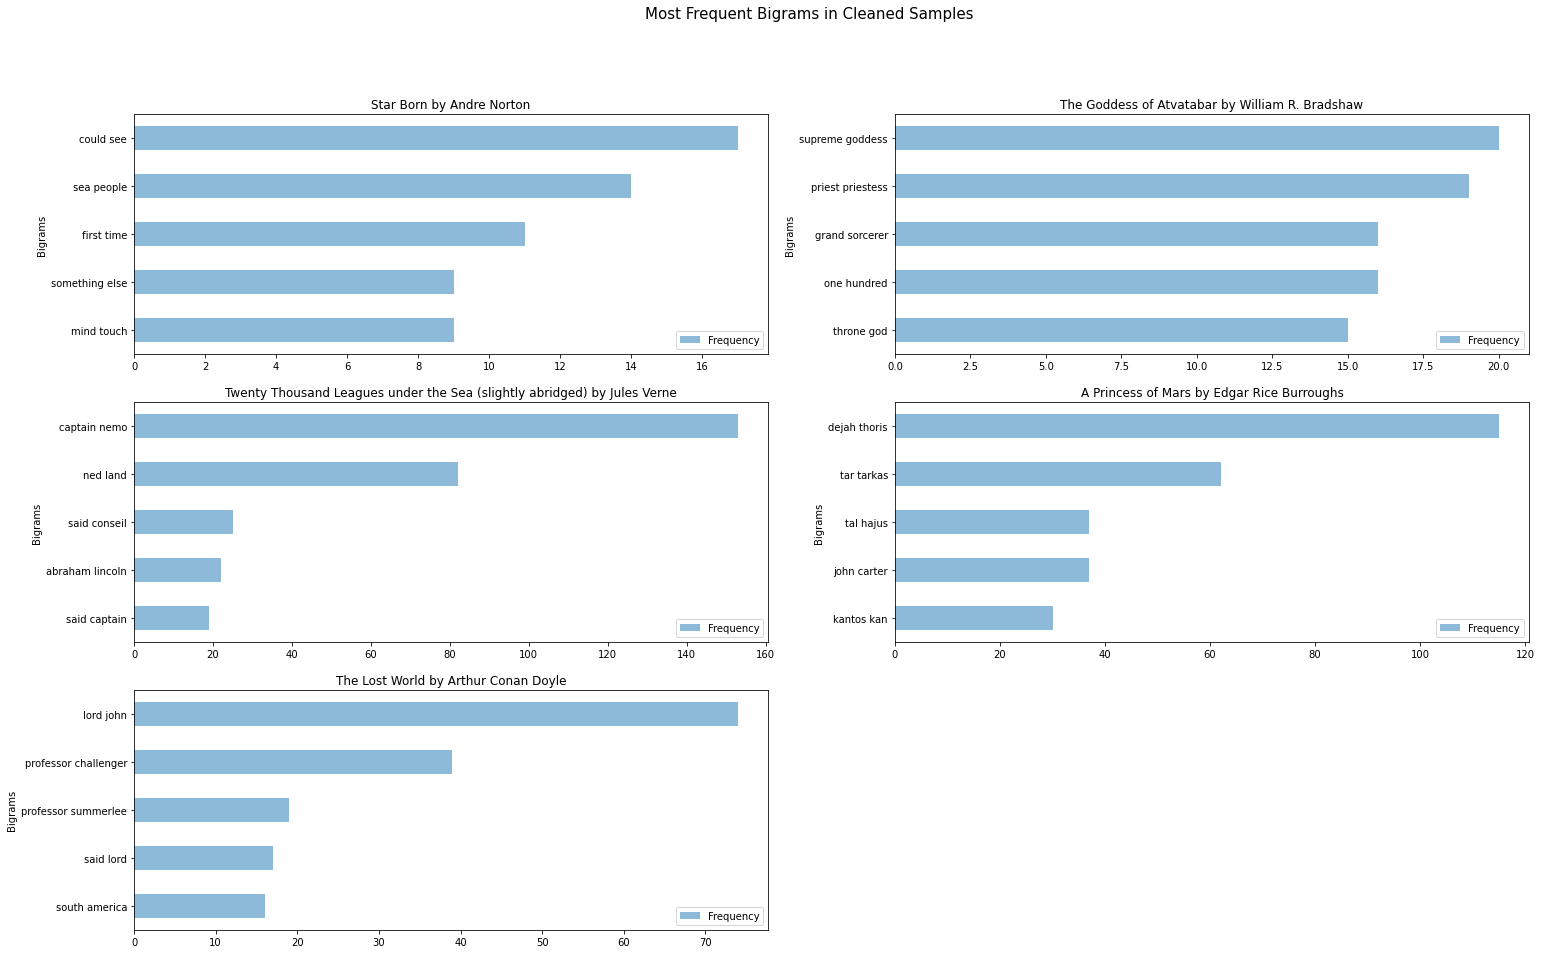

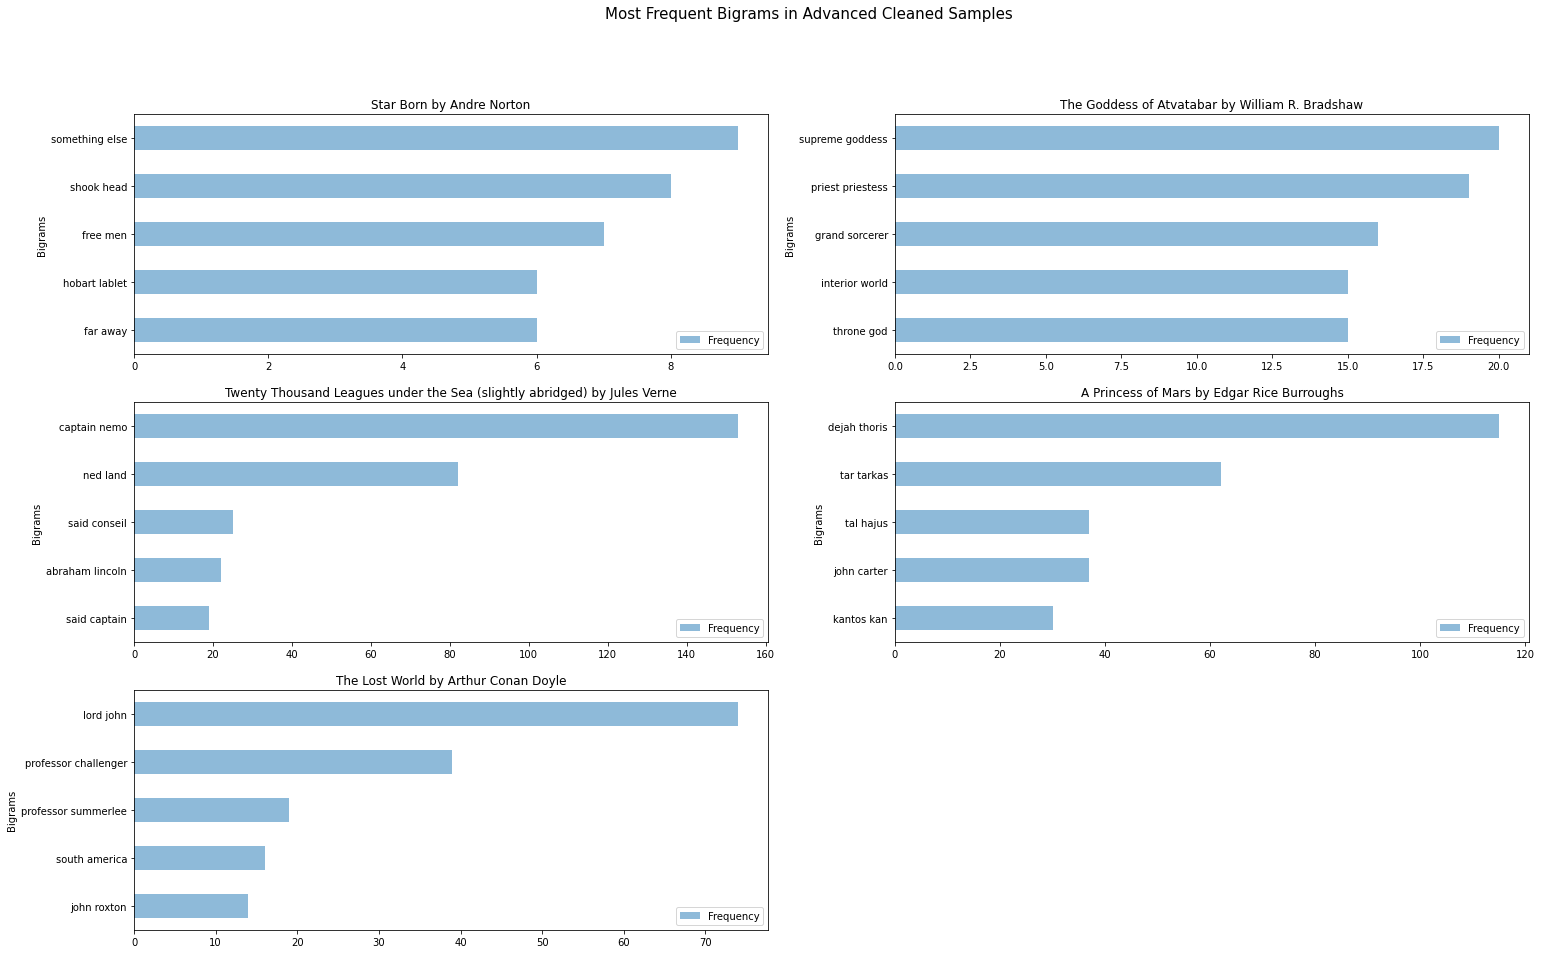

In [10]:
types = ["Cleaned Samples", "Advanced Cleaned Samples"]

for ty in types:
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25, 15))
    fig.suptitle("Most Frequent Bigrams in " + ty, fontsize=15)
    row = 0
    column = 0
    for a, t in zip(authors, titles):  
        corpus = labeled_texts_df[labeled_texts_df["Author"] == a][ty]
        tokens = word_tokenize(corpus.str.cat(sep=" "))
        freq_dist = FreqDist(nltk.ngrams(tokens, 2))
        dtf_bi = pd.DataFrame(freq_dist.most_common(5), columns=["Bigrams", "Frequency"])
        dtf_bi["Bigrams"] = dtf_bi["Bigrams"].apply(lambda x: " ".join(string for string in x) )
        dtf_bi.set_index("Bigrams").iloc[:].sort_values(by="Frequency").plot(kind="barh", ax=ax[row][column], width=0.5, alpha=0.5)
        title = t + " by " + a
        ax[row][column].set(title=title)
        if column < 1:         
            column += 1
        else:
            column = 0
            row += 1
    ax[2][1].set_visible(False)

Create text features with BOW and TFIDF for both cleaned and advanced cleaned samples

In [11]:
bow_cln_tr = CountVectorizer().fit(labeled_texts_df["Cleaned Samples"])
bow_cln_docs = bow_cln_tr.transform(labeled_texts_df["Cleaned Samples"])

bow_adv_cln_tr = CountVectorizer().fit(labeled_texts_df["Advanced Cleaned Samples"])
adv_cln_docs = bow_adv_cln_tr.transform(labeled_texts_df["Advanced Cleaned Samples"])

tfidf_cln_tr = TfidfTransformer().fit(bow_cln_docs)
tfidf_adv_cln_docs = tfidf_cln_tr.transform(bow_cln_docs)

tfidf_adv_cln_tr = TfidfTransformer().fit(adv_cln_docs)
documents_tfidf_2 = tfidf_adv_cln_tr.transform(adv_cln_docs)

Build pipelines and then train and evaluate models for both cleaned and advanced cleaned samples

In [12]:
clf_and_samp_type_to_avg_acc = {}

n_splits = 10
test_size = 0.1
random_state = 0

#
# Support Vector Machine (SVM)
#

# SVM + Cleaned Samples
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", SGDClassifier(loss="hinge", penalty="l2", alpha=1e-3, random_state=random_state, max_iter=5, tol=None))])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, labeled_texts_df["Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["SVM + Cleaned Samples"] = scores.mean()

# SVM + Advanced Cleaned Samples
pipeline = Pipeline([("bow", bow_adv_cln_tr),
                     ("tfidf", tfidf_adv_cln_tr),
                     ("clf", SGDClassifier(loss="hinge", penalty="l2", alpha=1e-3, random_state=random_state, max_iter=5, tol=None))])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
scores = cross_val_score(pipeline, labeled_texts_df["Advanced Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["SVM + Advanced Cleaned Samples"] = scores.mean()

#
# Decision Tree (DT)
#

# DT + Cleaned Samples
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", DecisionTreeClassifier(random_state=0))])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(pipeline, labeled_texts_df["Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["DT + Cleaned Samples"] = scores.mean()

# DT + Advanced Cleaned Samples
pipeline = Pipeline([("bow", bow_adv_cln_tr),
                     ("tfidf", tfidf_adv_cln_tr),
                     ("clf", DecisionTreeClassifier(random_state=0))])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(pipeline, labeled_texts_df["Advanced Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["DT + Advanced Cleaned Samples"] = scores.mean()

#
# KNeighbors (KN)
#

# KN + Cleaned Samples
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", KNeighborsClassifier(n_neighbors=3))])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(pipeline, labeled_texts_df["Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["KN + Cleaned Samples"] = scores.mean()

# KN + Advanced Cleaned Samples
pipeline = Pipeline([("bow", bow_adv_cln_tr),
                     ("tfidf", tfidf_adv_cln_tr),
                     ("clf", KNeighborsClassifier(n_neighbors=3))])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(pipeline, labeled_texts_df["Advanced Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["KN + Advanced Cleaned Samples"] = scores.mean()

#
# Random Forest (RF)
#

# RF + Cleaned Samples
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", RandomForestClassifier())])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(pipeline, labeled_texts_df["Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["RF + Cleaned Samples"] = scores.mean()

# RF + Advanced Cleaned Samples
pipeline = Pipeline([("bow", bow_adv_cln_tr),
                     ("tfidf", tfidf_adv_cln_tr),
                     ("clf", RandomForestClassifier())])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(pipeline, labeled_texts_df["Advanced Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["RF + Advanced Cleaned Samples"] = scores.mean()

#
# Naive Bayes (NB)
#

# NB + Cleaned Samples
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", MultinomialNB())])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(pipeline, labeled_texts_df["Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["NB + Cleaned Samples"] = scores.mean()

# NB + Advanced Cleaned Samples
pipeline = Pipeline([("bow", bow_adv_cln_tr),
                     ("tfidf", tfidf_adv_cln_tr),
                     ("clf", MultinomialNB())])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
scores = cross_val_score(pipeline, labeled_texts_df["Advanced Cleaned Samples"], labeled_texts_df["Author"], cv=cv)
clf_and_samp_type_to_avg_acc["NB + Advanced Cleaned Samples"] = scores.mean()

pd.DataFrame(clf_and_samp_type_to_avg_acc.items(), columns=["Classifier + Sample Type", "Average Accuracy"])

,Classifier + Sample Type,Average Accuracy
0,SVM + Cleaned Samples,0.997
1,SVM + Advanced Cleaned Samples,0.998
2,DT + Cleaned Samples,0.838
3,DT + Advanced Cleaned Samples,0.828
4,KN + Cleaned Samples,0.974
5,KN + Advanced Cleaned Samples,0.971
6,RF + Cleaned Samples,0.975
7,RF + Advanced Cleaned Samples,0.979
8,NB + Cleaned Samples,0.983
9,NB + Advanced Cleaned Samples,0.989


Score models

,Cleaned,Advanced Cleaned
SVM,0.997,0.998
DT,0.838,0.828
KN,0.974,0.971
RF,0.975,0.979
NB,0.983,0.989


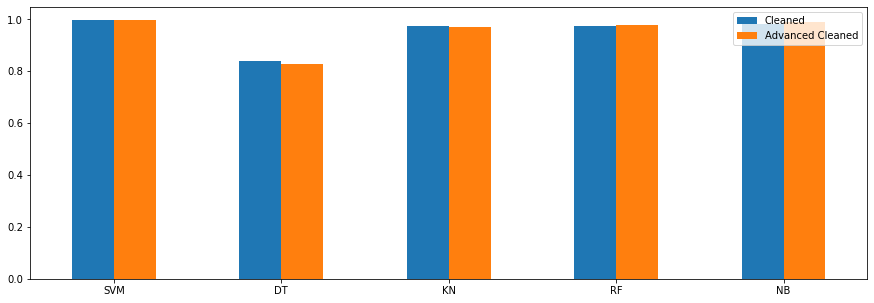

In [13]:
cln_acc = [clf_and_samp_type_to_avg_acc["SVM + Cleaned Samples"],
           clf_and_samp_type_to_avg_acc["DT + Cleaned Samples"],
           clf_and_samp_type_to_avg_acc["KN + Cleaned Samples"],
           clf_and_samp_type_to_avg_acc["RF + Cleaned Samples"],
           clf_and_samp_type_to_avg_acc["NB + Cleaned Samples"]]
adv_cln_acc = [clf_and_samp_type_to_avg_acc["SVM + Advanced Cleaned Samples"],
               clf_and_samp_type_to_avg_acc["DT + Advanced Cleaned Samples"],
               clf_and_samp_type_to_avg_acc["KN + Advanced Cleaned Samples"],
               clf_and_samp_type_to_avg_acc["RF + Advanced Cleaned Samples"],
               clf_and_samp_type_to_avg_acc["NB + Advanced Cleaned Samples"]]
index = ["SVM", "DT", "KN", "RF", "NB"]
cross_validation_scores_df = pd.DataFrame({"Cleaned": cln_acc, "Advanced Cleaned": adv_cln_acc}, index = index)
cross_validation_scores_df.plot.bar(figsize=[15, 5], rot=0)
cross_validation_scores_df

Display results

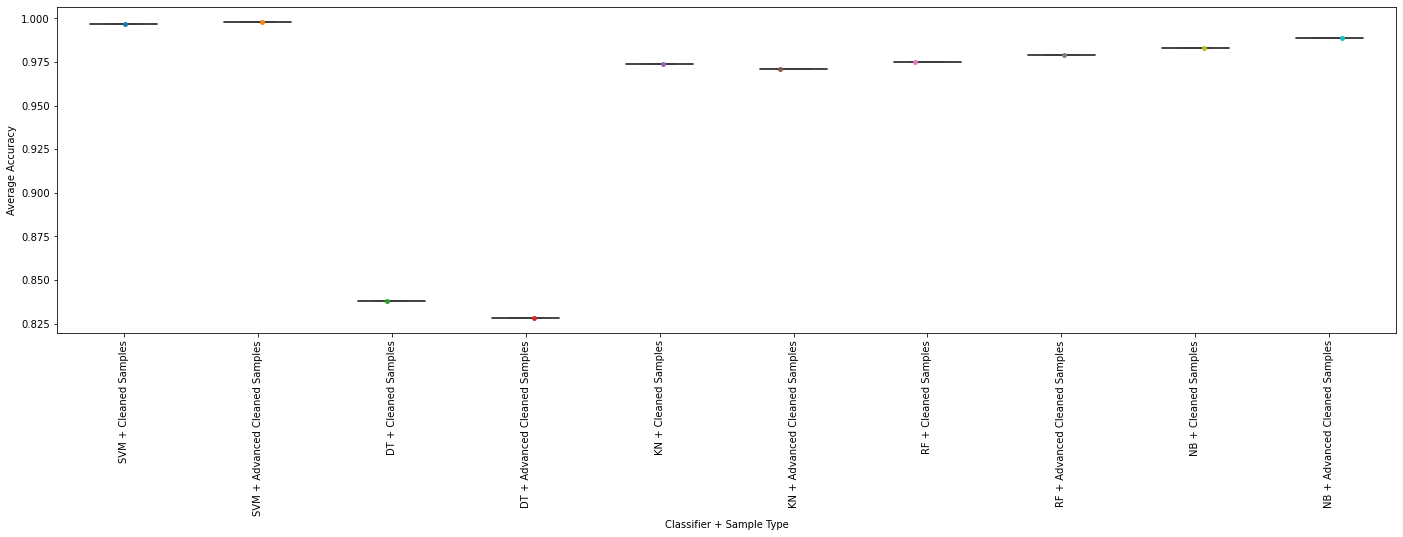

In [14]:
bow_scores_df = pd.DataFrame(clf_and_samp_type_to_avg_acc.items(), columns=["Classifier + Sample Type", "Average Accuracy"])
sns.boxplot(x="Classifier + Sample Type",
            y="Average Accuracy",
            data=bow_scores_df,
            width=0.5,
            fliersize=10)
sns.stripplot(x="Classifier + Sample Type",
              y="Average Accuracy",
              data=bow_scores_df,
              size=5,
              jitter=True)
plt.xticks(rotation=90)
plt.show()

Test document that does not include labels using champion models (NB and SVM)

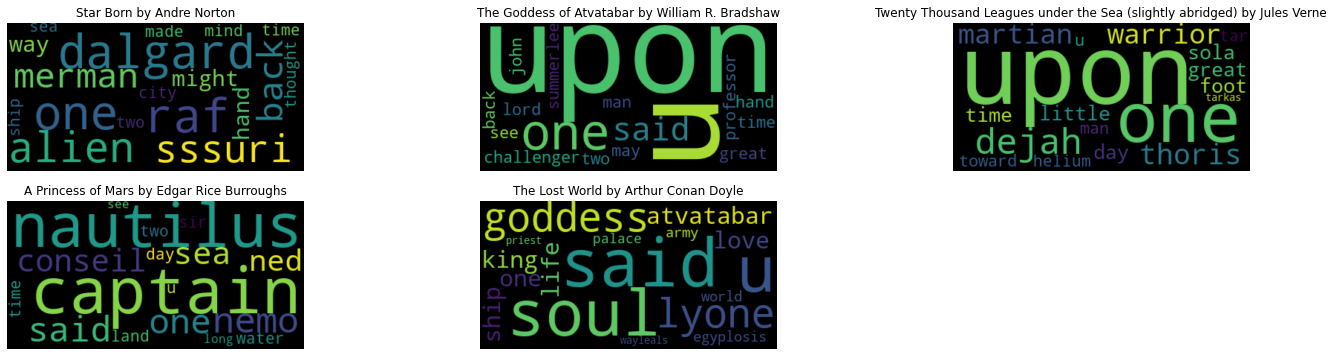

In [15]:
predict_text = sampled_text
for a, sat in zip(authors, predict_text):
    labeled_texts += ([(txt, a) for txt in sat])
    
predict_document = pd.DataFrame(labeled_texts)
predict_document = labeled_texts_df.rename(columns={0: "Cleaned Samples",
                                                    1: "Author"})
clean_text_advanced(predict_document, authors, titles, rem_com=True)
predict_document = predict_document.sample(frac=1).reset_index(drop=True)

In [16]:
bow_cln_tr = CountVectorizer().fit(predict_document["Cleaned Samples"])
bow_cln_docs = bow_cln_tr.transform(predict_document["Cleaned Samples"])

bow_adv_cln_tr = CountVectorizer().fit(predict_document["Advanced Cleaned Samples"])
adv_cln_docs = bow_adv_cln_tr.transform(predict_document["Advanced Cleaned Samples"])

tfidf_cln_tr = TfidfTransformer().fit(bow_cln_docs)
tfidf_adv_cln_docs = tfidf_cln_tr.transform(bow_cln_docs)

tfidf_adv_cln_tr = TfidfTransformer().fit(adv_cln_docs)
documents_tfidf_2 = tfidf_adv_cln_tr.transform(adv_cln_docs)

Seperate training and test data sets

In [17]:
x_train_cln, x_test_cln, y_train_cln, y_test_cln = train_test_split(labeled_texts_df["Cleaned Samples"], labeled_texts_df["Author"], test_size=0.1)
x_train_adv_cln, x_test_adv_cln, y_train_adv_cln, y_test_adv_cln = train_test_split(labeled_texts_df["Advanced Cleaned Samples"], labeled_texts_df["Author"], test_size=0.1)

Perform test and conduct error analysis

NB + Cleaned Samples
             Prediction               Actual  Predicted Wrong
460  Arthur Conan Doyle  William R. Bradshaw            False
728         Jules Verne  William R. Bradshaw            False
952  Arthur Conan Doyle  William R. Bradshaw            False
NB + Advanced Cleaned Samples
Empty DataFrame
Columns: [Prediction, Actual, Predicted Wrong]
Index: []
NB + Cleaned Samples
                      precision    recall  f1-score   support

        Andre Norton       1.00      1.00      1.00       200
  Arthur Conan Doyle       1.00      0.99      1.00       202
Edgar Rice Burroughs       1.00      1.00      1.00       200
         Jules Verne       1.00      1.00      1.00       201
 William R. Bradshaw       0.98      1.00      0.99       197

            accuracy                           1.00      1000
           macro avg       1.00      1.00      1.00      1000
        weighted avg       1.00      1.00      1.00      1000

NB + Advanced Cleaned Samples
                

Text(0.5, 51.0, 'Predicted')

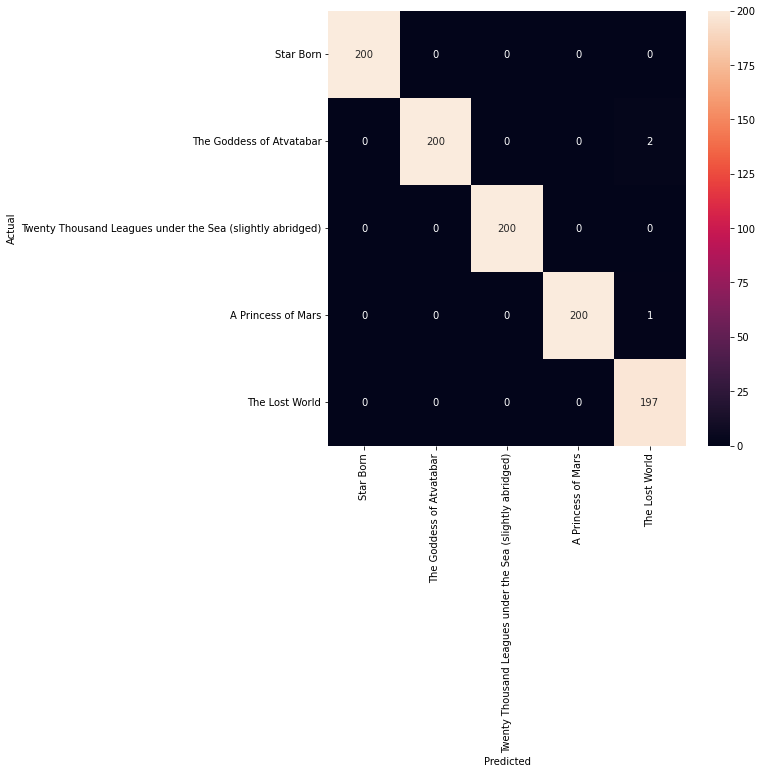

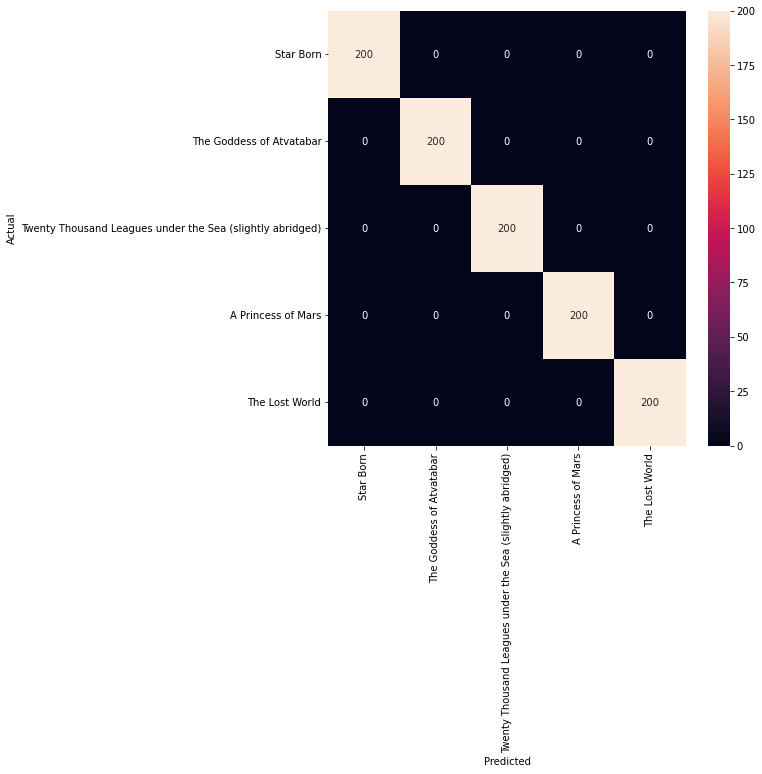

In [18]:
#
# Champion Classifier: NB
#

# NB + Cleaned Samples
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", MultinomialNB())])
pipeline.fit(x_train_cln, y_train_cln)
predictions_cln = pipeline.predict(predict_document["Cleaned Samples"])

# NB + Advanced Cleaned Samples
pipeline = Pipeline([("bow", bow_adv_cln_tr),
                     ("tfidf", tfidf_adv_cln_tr),
                     ("clf", MultinomialNB())])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
pipeline.fit(x_train_adv_cln, y_train_adv_cln)
predictions_adv_cln = pipeline.predict(predict_document["Advanced Cleaned Samples"])

# Extract wrong predictions
print("NB + Cleaned Samples")
df = pd.DataFrame({"Prediction": predictions_cln, "Actual": predict_document["Author"]})
df["Predicted Wrong"] = df.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
rslt_df = df[df["Predicted Wrong"] == False]
print(rslt_df)

# Extract wrong predictions
print("NB + Advanced Cleaned Samples")
df = pd.DataFrame({"Prediction": predictions_adv_cln, "Actual": predict_document["Author"]})
df["Predicted Wrong"] = df.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
rslt_df = df[df["Predicted Wrong"] == False]
print(rslt_df)

print("NB + Cleaned Samples")
report = classification_report(predictions_cln,predict_document["Author"])
print(report)
conf_mat = confusion_matrix(predictions_cln, predict_document["Author"])
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=titles, yticklabels=titles)
plt.ylabel("Actual")
plt.xlabel("Predicted")

print("NB + Advanced Cleaned Samples")
report = classification_report(predictions_adv_cln,predict_document["Author"])
print(report)
conf_mat = confusion_matrix(predictions_adv_cln, predict_document["Author"])
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=titles, yticklabels=titles)
plt.ylabel("Actual")
plt.xlabel("Predicted")

SVM + Cleaned Samples
Empty DataFrame
Columns: [Prediction, Actual, Predicted Wrong]
Index: []
SVM + Advanced Cleaned Samples
             Prediction        Actual  Predicted Wrong
720  Arthur Conan Doyle  Andre Norton            False
SVM + Cleaned Samples
                      precision    recall  f1-score   support

        Andre Norton       1.00      1.00      1.00       200
  Arthur Conan Doyle       1.00      1.00      1.00       200
Edgar Rice Burroughs       1.00      1.00      1.00       200
         Jules Verne       1.00      1.00      1.00       200
 William R. Bradshaw       1.00      1.00      1.00       200

            accuracy                           1.00      1000
           macro avg       1.00      1.00      1.00      1000
        weighted avg       1.00      1.00      1.00      1000

SVM + Advanced Cleaned Samples
                      precision    recall  f1-score   support

        Andre Norton       0.99      1.00      1.00       199
  Arthur Conan Doyle     

Text(0.5, 51.0, 'Predicted')

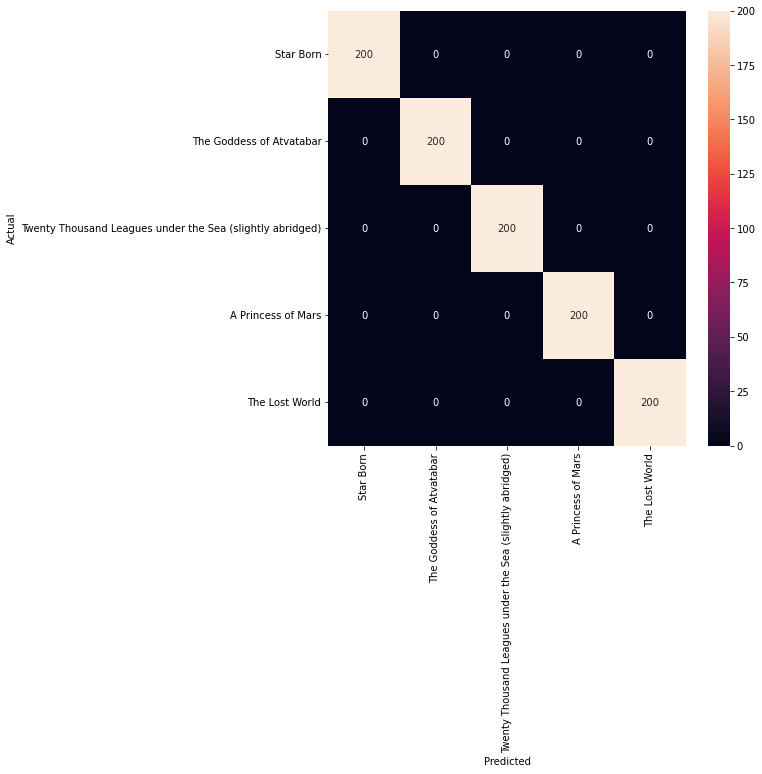

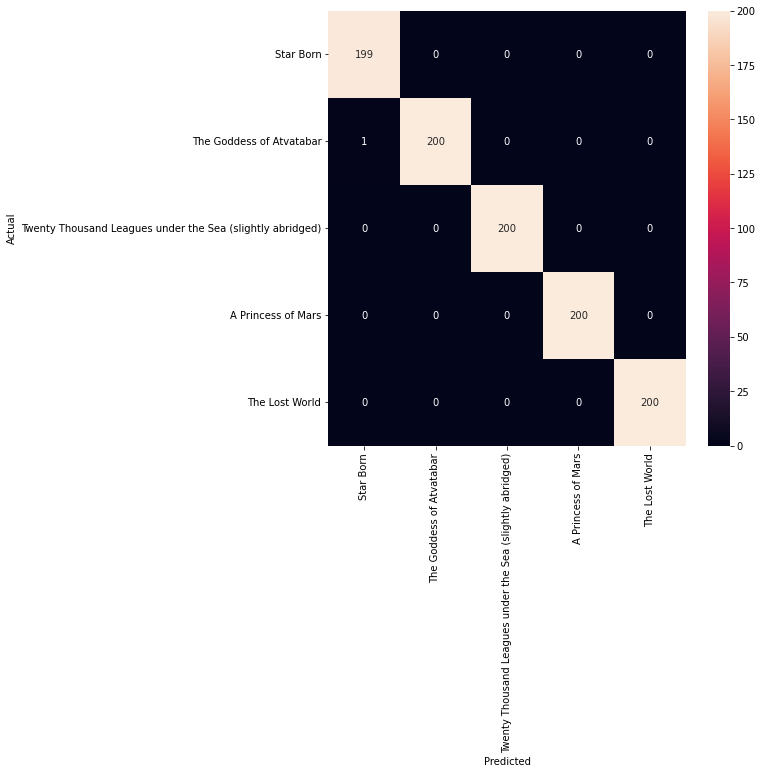

In [19]:
#
# Champion Classifier: SVM
#

# SVM + Cleaned Samples
pipeline = Pipeline([("bow", bow_cln_tr),
                     ("tfidf", tfidf_cln_tr),
                     ("clf", SGDClassifier(loss="hinge", penalty="l2", alpha=1e-3, random_state=random_state, max_iter=5, tol=None))])
pipeline.fit(x_train_cln, y_train_cln)
predictions_cln = pipeline.predict(predict_document["Cleaned Samples"])

# SVM + Advanced Cleaned Samples
pipeline = Pipeline([("bow", bow_adv_cln_tr),
                     ("tfidf", tfidf_adv_cln_tr),
                     ("clf", SGDClassifier(loss="hinge", penalty="l2", alpha=1e-3, random_state=random_state, max_iter=5, tol=None))])
cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
pipeline.fit(x_train_cln, y_train_cln)
predictions_adv_cln = pipeline.predict(predict_document["Advanced Cleaned Samples"])

# Extract wrong predictions
print("SVM + Cleaned Samples")
df = pd.DataFrame({"Prediction": predictions_cln, "Actual": predict_document["Author"]})
df["Predicted Wrong"] = df.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
rslt_df = df[df["Predicted Wrong"] == False]
print(rslt_df)

# Extract wrong predictions
print("SVM + Advanced Cleaned Samples")
df = pd.DataFrame({"Prediction": predictions_adv_cln, "Actual": predict_document["Author"]})
df["Predicted Wrong"] = df.apply(lambda x: x["Prediction"] == x["Actual"], axis=1)
rslt_df = df[df["Predicted Wrong"] == False]
print(rslt_df)

print("SVM + Cleaned Samples")
report = classification_report(predictions_cln,predict_document["Author"])
print(report)
conf_mat = confusion_matrix(predictions_cln, predict_document["Author"])
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=titles, yticklabels=titles)
plt.ylabel("Actual")
plt.xlabel("Predicted")

print("SVM + Advanced Cleaned Samples")
report = classification_report(predictions_adv_cln,predict_document["Author"])
print(report)
conf_mat = confusion_matrix(predictions_adv_cln, predict_document["Author"])
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=titles, yticklabels=titles)
plt.ylabel("Actual")
plt.xlabel("Predicted")